<a href="https://colab.research.google.com/github/babymlin/face_recognition/blob/main/Siamese%40MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

# from keras.datasets import mnist
# from keras.models import Model
# from keras.layers import Input, Flatten, Dense, Dropout, Lambda
# from keras.optimizers import RMSprop, Adam
# from keras import backend as K
# from keras.utils import plot_model


num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # Positive
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
tr_y = tr_y.astype('float32')
te_y = te_y.astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
tr_pairs[0].shape, tr_y[0]

((2, 28, 28), 1.0)

In [4]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
          output_shape=eucl_dist_output_shape)([processed_a, processed_b])
# sum_square = K.sum(K.square(processed_a - processed_b), axis=1, keepdims=True)
# distance = K.sqrt(K.maximum(sum_square, K.epsilon()))

model = Model([input_a, input_b], distance)

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

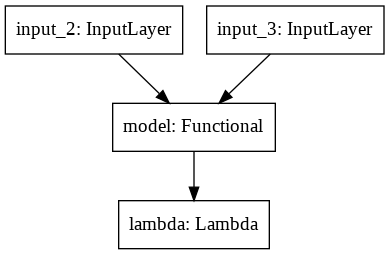

In [6]:
plot_model(model)

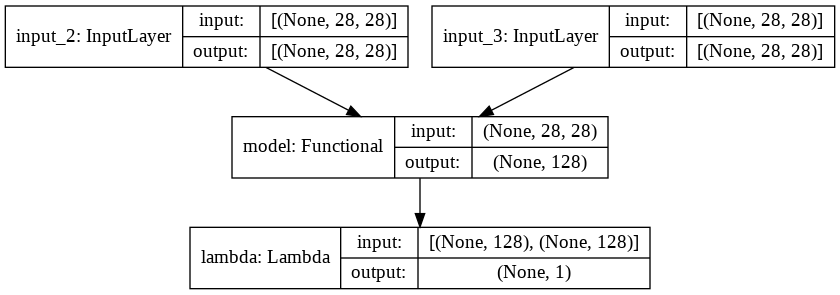

In [7]:
plot_model(model, show_shapes=True)

In [8]:
# train
model.compile(loss=contrastive_loss, 
              optimizer='adam', 
              metrics=['accuracy'])

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 7s 4ms/step - loss: 0.1046 - accuracy: 0.1289 - val_loss: 0.0449 - val_accuracy: 0.0476
Epoch 2/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0434 - accuracy: 0.0440 - val_loss: 0.0307 - val_accuracy: 0.0333
Epoch 3/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0298 - accuracy: 0.0308 - val_loss: 0.0267 - val_accuracy: 0.0304
Epoch 4/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0245 - accuracy: 0.0260 - val_loss: 0.0261 - val_accuracy: 0.0302
Epoch 5/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0207 - accuracy: 0.0222 - val_loss: 0.0248 - val_accuracy: 0.0283
Epoch 6/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0183 - accuracy: 0.0197 - val_loss: 0.0240 - val_accuracy: 0.0282
Epoch 7/20
847/847 [==============================] - 3s 3ms/step - loss: 0.0165 - accuracy: 0.0179 - val_loss: 0.0251 - val_accuracy: 0.0299
Epoch 

In [9]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.44%
* Accuracy on test set: 97.03%


idx: 9284
Same ?:  1.0


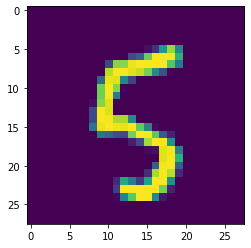

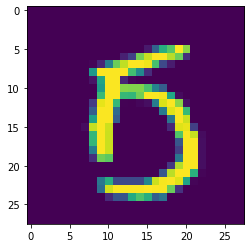

In [14]:
idx = np.random.randint(0, te_pairs.shape[0])
print('idx:', idx)
print('Same ?: ', te_y[idx])
plt.imshow(te_pairs[idx, 0])
plt.show()
plt.imshow(te_pairs[idx, 1])
plt.show()

In [15]:
model.predict([te_pairs[idx:idx+1, 0], te_pairs[idx:idx+1, 1]])

array([[0.35864258]], dtype=float32)